# K - Epsilon from scratch 
A Notebook where we build the K-epsilon turbulence model from scratch to model water flowing in a 1D channel. We then compare to DNS measurement

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd

Define constants

In [3]:
rho = 1e3   #density
nu = 1e-4   # kinematic viscosity
N = 2000    # number of cells
H = 2       # height of channel
dy = H/N



Define the functions
- solve the turbulent kinetic energy equation k
- solve the dissipation of kinetic energy e
- solve for the velocity field
- solve damping term

In [5]:
def solve_kinetic(k,e,nu_tk,dy,N,cmu,sigk,sige,Ce1,Ce2):
    """
    Function where we numerically solve the turbulent kinetic energy field in the channel
    """
    Ak = sp.diags([np.append(nu_tk[1:-1]/dy**2-(nu_tk[2:]-nu_tk[:-2])/(4*dy**2),0),-2*nu_tk/dy**2-e/k,np.append(0,nu_tk[1:-1]/dy**2+(nu_tk[2:]-nu_tk[:-2])/(4*dy**2))],[-1,0,1],shape=(N+1,N+1)).tocsr()
        
    Ak[0,0] = 1
    Ak[-1,-1] = 1
    
    bk = -(nu_e+nu)*(dudy**2)
    bk[0] = 0
    bk[-1] = 0
    k = la.spsolve(Ak,bk)
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)
    
    return k

In [6]:
def solve_epsilon(k,e,nu_tk,dy,N,cmu,sigk,sige,Ce1,Ce2):
    """
    Function where we numerically solve the dissipation of turbulent kinetic energy field in the channel
    """
    Ae = sp.diags([np.append(nu_te[1:-1]/dy**2-(nu_te[2:]-nu_te[:-2])/(4*dy**2),0),-2*nu_te/dy**2-Ce2*e/k,np.append(0,nu_te[1:-1]/dy**2+(nu_te[2:]-nu_te[:-2])/(4*dy**2))],[-1,0,1],shape=(N+1,N+1)).tocsr()    
    Ae[0,0] = 1
    Ae[0,1] = -1
    Ae[-1,-1] = 1
    Ae[-1,-2] = -1
    
    be = -Ce1*e[1:-1]/k[1:-1]*(nu_e[1:-1]+nu)*(dudy[1:-1]**2)
    
    be = np.append(0,be)
    be = np.append(be,0)

    e = la.spsolve(Ae,be)
    e[1:-1] = np.maximum(e[1:-1], 1.e-12)
    
    return e

In [9]:
def solve_velocity(nu, nu_e, dy, N,b):
    """
    Function where we numerically solve the velocity field in the channel
    """
    A = sp.diags([nu+nu_e[1:-1],-2*nu-nu_e[1:]-nu_e[:-1],nu+nu_e[1:-1]],[-1,0,1],shape=(N,N)).tocsr()
    A[0,0] = -3*nu-nu_e[1]
    A[0,1] = nu+nu_e[1]
    
    A[-1,-1] = -3*nu-nu_e[-2]
    A[-1,-2] = nu+nu_e[-2]
    
    U = la.spsolve(A,b)
    
    dudy = (U[1:]-U[0:-1])/dy
    dudy = np.append(2*U[0]/dy,dudy)
    dudy = np.append(dudy,-2*U[-1]/dy)
    
    return U,dudy

In [10]:
def damping_function(A,nu,rho,U,dy,delta):
    """
    compute damping terms near the wall
    """
    tau = 2*nu*rho*U[0]/dy
    u_tau = np.sqrt(tau/rho)
    y_plus = np.append(y[y<=delta]*u_tau/nu,(H-y[y>delta])*u_tau/nu)
    fmu = (1-np.exp(-y_plus/A))**2
    
    return fmu,tau,u_tau,y_plus

Load in DNS data to which we can compare our solution

In [11]:
data= pd.read_csv('dns_dat.csv')
y_c = np.linspace(dy/2,H-dy/2,N)
y = np.linspace(0,H,N+1)
delta = H/2
kappa = 0.41
lm = kappa*0.2*delta*np.ones(N+1)
lm[y<=0.2*delta] = kappa*y[y<=0.2*delta] 
lm[y>=(H-0.2*delta)] = kappa*(H-y[y>=(H-0.2*delta)]) 
omega = 0.30

Re_d = 78571.57671218543

U_mean = Re_d*nu/2/H
A = ((-2.457*np.log(1/((7/Re_d)**(0.9))))**16)
B = ((37530/Re_d)**16)
f_church = 0.55*8*((8/Re_d)**12 + 1/((A+B)**(1.5)))**(1/12)  
        
#f_church = 64/Re_d
dp_dx = (f_church*rho*U_mean**2)/(2*H)
dpdx = -dp_dx*np.ones(N)
tau = 1/4*f_church*rho*U_mean**2
u_tau = np.sqrt(tau/rho)
re_tau = u_tau*delta/nu
b = dpdx*dy**2/rho
print(re_tau)


999.0


Run simulation. Solve for the velocity, turbulent kinetic energy, dissipation of kinetic energy fields iteratively until one converges on a solution

In [12]:
U,dudy = solve_velocity(nu, np.zeros(N+1), dy, N,b)
Re = np.max(U)*H/nu

nu_e = lm**2*np.abs(dudy)


e = 0.001*np.ones(N+1)
k = 0.01*np.ones(N+1)
cmu  = 0.09 
sigk = 1.4 
sige = 1.3 
Ce1  = 1.4 
Ce2  = 1.8

nu_tk = nu_e/sigk + nu
nu_te = nu_e/sige + nu


U_old = 0

err = np.linalg.norm(U-U_old)/N
print(err)

while err >= 1e-12:  

    
    fmu,tau,u_tau,y_plus = damping_function(32,nu,rho,U,dy,delta)
    k = solve_kinetic(k,e,nu_tk,dy,N,cmu,sigk,sige,Ce1,Ce2)
    e = solve_epsilon(k,e,nu_tk,dy,N,cmu,sigk,sige,Ce1,Ce2)
    nu_e = cmu*fmu[1:-1]*(k[1:-1]**2)/e[1:-1]
    nu_e = np.append(0,nu_e)
    nu_e = np.append(nu_e,0)
    
    U,dudy = solve_velocity(nu, nu_e, dy, N,b)

    
    nu_tk = nu_e/sigk + nu
    nu_te = nu_e/sige + nu
    
    err = np.linalg.norm(U-U_old)/N
    U_old = np.copy(U)


0.814864658906664


/var/folders/d5/v9jsvp8n49v35__8crz3qh500000gn/T/ipykernel_40917/1388204571.py:5: RuntimeWarning: divide by zero encountered in divide
  Ae = sp.diags([np.append(nu_te[1:-1]/dy**2-(nu_te[2:]-nu_te[:-2])/(4*dy**2),0),-2*nu_te/dy**2-Ce2*e/k,np.append(0,nu_te[1:-1]/dy**2+(nu_te[2:]-nu_te[:-2])/(4*dy**2))],[-1,0,1],shape=(N+1,N+1)).tocsr()
/Users/tammodukker/opt/anaconda3/envs/venv_PhysicsX/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [13]:
Plot the velocity, turbulent kinetic energy, dissipation of kinetic energy fields

SyntaxError: invalid syntax (2440851573.py, line 1)

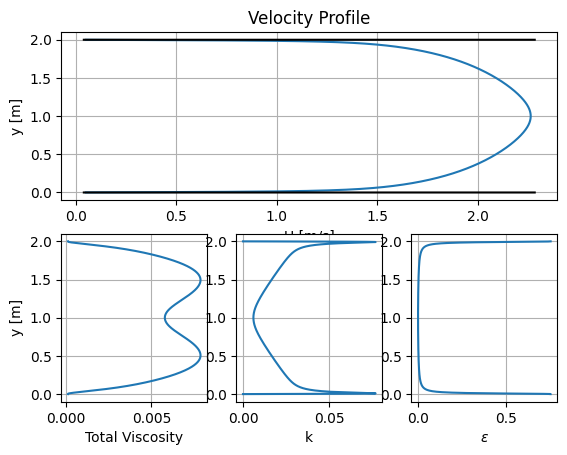

In [10]:
x = np.linspace(np.min(U)-0.01,np.max(U)+0.02,N-2)

plt.subplot(2,3,(1,3))

plt.plot(U,y_c)

plt.plot(x,np.repeat(0,len(x)),'black')
plt.plot(x,np.repeat(H,len(x)),'black')

plt.xlabel('U [m/s]')
plt.ylabel('y [m]')
plt.grid()
plt.title('Velocity Profile')
plt.subplot(2,3,4)
plt.plot(nu_e+nu,y)
plt.grid()
plt.xlabel('Total Viscosity')
plt.ylabel('y [m]')
plt.subplot(2,3,5)
plt.plot(k,y)
plt.grid()
plt.xlabel('k')

plt.subplot(2,3,6)
plt.plot(e,y)
plt.xlabel('$\epsilon$')


plt.grid()


Plot results compared to DNS data

Text(0, 0.5, 'y [m]')

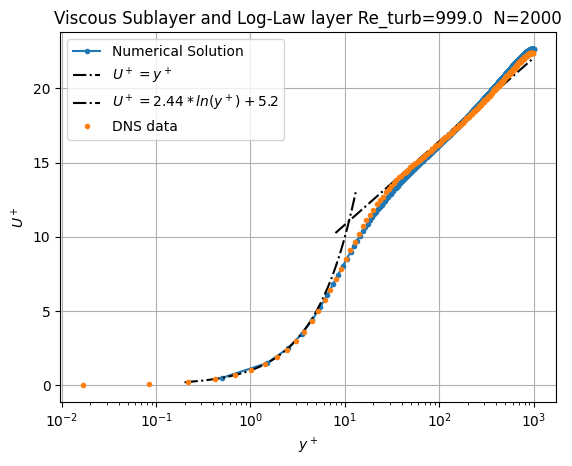

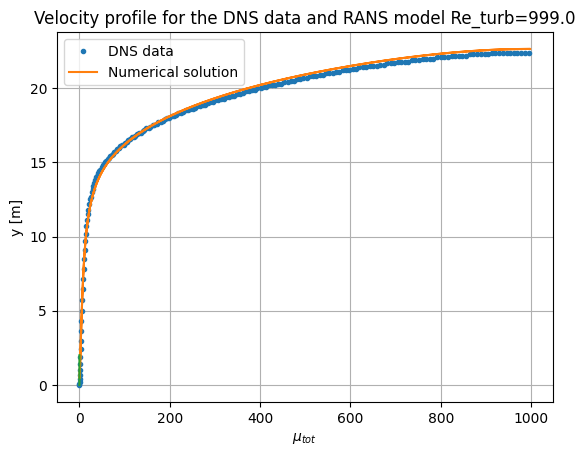

In [11]:
plt.figure(2)

u_tau = np.sqrt(tau/rho)
y_plus = np.append(y_c[y_c<=delta]*u_tau/nu,(H-y_c[y_c>delta])*u_tau/nu)
plt.semilogx(y_plus[:N//2],U[:N//2]/u_tau,'.-',label='Numerical Solution')
#plt.semilogx(y_plus[y_plus<10],y_plus[y_plus<10])
plt.xlabel('$y^+$')
plt.ylabel('$U^+$')
plt.title('Viscous Sublayer and Log-Law layer Re_turb='+str(round(re_tau, 2))+'  N='+str(N))
ypLam = np.linspace(0.2,13,100); 
plt.semilogx(ypLam, ypLam,'k-.',label='$U^+ = y^+$')
ypTurb = np.linspace(0.9,3,20); 
upTurb = 2.44*np.log(np.power(10, ypTurb))+5.2
plt.semilogx(np.power(10, ypTurb), upTurb,'k-.',label='$U^+ = 2.44*ln(y^+)+5.2$')

y_dns = np.array(data['y+'])
u_mean = np.array(data['U+'])
plt.semilogx(y_dns, u_mean,'.',label='DNS data')
plt.legend()
plt.grid()
plt.figure(4)

plt.plot(y_dns, u_mean,'.',label='DNS data')
plt.plot(y_plus, U/u_tau,label= 'Numerical solution')
plt.title('Velocity profile for the DNS data and RANS model Re_turb='+str(round(re_tau, 2)))
plt.xlabel('$y^+$')
plt.ylabel('$U^+$')
plt.legend()
plt.grid()
#%%
plt.figure
plt.plot(nu_e+nu,y)
plt.xlabel('$\mu_{tot}$')
plt.ylabel('y [m]')

